# Transformation Equations:  ComCam DP1 <--> SDSS DR18

_Meagan N. Porter, Douglas L. Tucker, Christina L. Adair_

_2025.6.29_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## 2. Input Parameters

In [2]:
# ComCam-->SDSS DR18 (toComCam=False) or SDSS DR18-->ComCam (toComCam=True)...
#toComCam = True
toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    #bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam']
    # If SDSS-->ComCam, then the mag and color to fit against are SDSS...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_ComCam':'g_sdss', 'r_ComCam':'r_sdss', 'i_ComCam':'i_sdss', 'z_ComCam':'z_sdss', 'y_ComCam':'z_sdss'}
    # Color to fit against...
    color_name_1_dict = {'g_ComCam':'gi_sdss', 'r_ComCam':'gi_sdss', 'i_ComCam':'gi_sdss', 'z_ComCam':'gi_sdss', 'y_ComCam':'gi_sdss'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_ComCam':'$(g-i)_{sdss}$', 'r_ComCam':'$(g-i)_{sdss}', 'i_ComCam':'$(g-i)_{sdss}', 'z_ComCam':'$(g-i)_{sdss}', 'y_ComCam':'$(g-i)_{sdss}'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...
    color_limits_1_dict = {'g_ComCam':[-10.,10.], 
                           'r_ComCam':[-10.,10.], 
                           'i_ComCam':[-10.,10.],
                           'z_ComCam':[-10.,10.],
                           'y_ComCam':[-10.,10.]}
    
    
else:
    # List of SDSS bands on which to run the transform fit...
    bandList = ['g_sdss', 'r_sdss', 'i_sdss', 'z_sdss']
    # If ComCam-->SDSS, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_sdss':'g_ComCam', 'r_sdss':'r_ComCam', 'i_sdss':'i_ComCam', 'z_sdss':'z_ComCam', 'y_sdss':'z_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'g_sdss':'gi_ComCam', 'r_sdss':'gi_ComCam', 'i_sdss':'gi_ComCam', 'z_sdss':'gi_ComCam', 'y_sdss':'gi_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_sdss':'$(g-i)_{ComCam}$', 'r_sdss':'$(g-i)_{ComCam}', 'i_sdss':'$(g-i)_{ComCam}', 'z_sdss':'$(g-i)_{ComCam}', 'y_sdss':'$(g-i)_{ComCam}'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...    
    color_limits_1_dict = {'g_sdss':[-10.,10.], 
                           'r_sdss':[-10.,10.], 
                           'i_sdss':[-10.,10.],
                           'z_sdss':[-10.,10.]}

# Order of polynomial fits...
norder = 1

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# ComCam data
collection='LSSTComCam/DP1'
repo = 'dp1'
skymap = 'lsst_cells_v1'
instrument = 'LSSTComCam'

# PanSTARRS1 DR2 TAP service
sdss_tap_url = ''#'https://mast.stsci.edu/vo-tap/api/v0.1/ps1dr2'

#use match file?
useMatchFile = True

# Name of the match file
#matchFile = './match_ComCam_Stetson_UBVRI.csv'
matchFile = '/home/d/dltucker/DATA/match.comcam_stars_all.w_2025_10.DM-49359a.SDSS_DR18.csv'

# Base name of fit results output file...
#if toComCam:
#    resultsFileBaseName = 'transFit.PS1DR2_to_ComCam'
#else:
#    resultsFileBaseName = 'transFit.ComCam_to_PS1DR2'

# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.SDSS_to_ComCam.fit'
else:
    qaFileBaseName = 'qaPlot.ComCam_to_SDSS.fit'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }

## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Additional mask to ensure indices are valid
    valid_idx_mask = idx[mask] < len(df2)
    combined_mask = mask.copy()
    combined_mask[mask] = valid_idx_mask
    
    # Create a new dataframe with matches
    matches = df1[combined_mask].copy()
    matches['match_idx'] = idx[combined_mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[combined_mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        #matches[f'match_{col}'] = df2.loc[idx[mask], col].values
        # This is a safer way to to this, avoid out-of-bound indices:
        matches[f'match_{col}'] = df2.iloc[idx[combined_mask]][col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~combined_mask]

    return matches, unmatched

In [5]:
def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plotText, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})
    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    if len(dmag) < 1000:
        plt.scatter(color1, dmag, alpha=0.75)
        #hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno_r')
    else:
        hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    if len(dmag) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    if len(res) < 100:
        plt.hist(res,bins=10)
    else:
        plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224)
    if len(res) < 1000:
        plt.scatter(color1, res, alpha=0.75)
        #hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno_r')
    else:
        hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    if len(res) >= 1000:
        cb = plt.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################


In [6]:
# Kudos to Claude-3.5-Sonnet for improving on old outlier rejection code...

def poly_fit_with_sigma_clip(x, y, degree=1, sigma=3.0, maxiters=5):
    """
    Perform polynomial fit with iterative sigma clipping
    
    Parameters:
    -----------
    x : array-like
        Independent variable
    y : array-like 
        Dependent variable
    degree : int
        Degree of polynomial fit
    sigma : float
        Sigma clipping threshold
    maxiters : int
        Maximum number of sigma clipping iterations
        
    Returns:
    --------
    coeffs : array
        Polynomial coefficients
    mask : array
        Boolean mask indicating non-clipped points
    rms : float
        RMS of residuals
    """

    # Import relevant modules
    import numpy as np
    from astropy.stats import sigma_clip
    
    # Initial fit using all points
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.ones_like(x, dtype=bool)
    
    for _ in range(maxiters):
        print(len(x[mask]), len(y[mask]), len(mask))

        # Fit polynomial to non-masked points
        coeffs, cov = np.polyfit(x[mask], y[mask], degree, cov=True)
        
        # Calculate residuals
        yfit = np.polyval(coeffs, x)
        residuals = y - yfit
        
        # Update mask with sigma clipping
        new_mask = ~sigma_clip(residuals, sigma=sigma).mask
        
        # Check for convergence
        if np.array_equal(mask, new_mask):
            break
        
        mask = new_mask
    
    # Calculate final RMS
    final_residuals = y[mask] - np.polyval(coeffs, x[mask])
    rms = np.sqrt(np.mean(final_residuals**2))

    print(len(x[mask]), len(y[mask]), len(mask))

    # Calculate coefficient errors from diagonal of covariance matrix
    coeff_errors = np.sqrt(np.diag(cov))
        
    return coeffs, coeff_errors, x[mask], y[mask], final_residuals, rms

## X. Read in Matched Catalog

In [7]:
#matchFile = os.path.join(matchDir,matchFile)
#print(matchFile)

In [8]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


matchFile:  /home/d/dltucker/DATA/match.comcam_stars_all.w_2025_10.DM-49359a.SDSS_DR18.csv


In [9]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    display(tab)

tractId,field,coord_ra,coord_dec,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,g_psfFluxErr,g_ap12Flux,g_ap12FluxErr,g_extendedness,g_psfFlux_flag,r_psfFlux,r_psfFluxErr,r_ap12Flux,r_ap12FluxErr,r_extendedness,r_psfFlux_flag,i_psfFlux,i_psfFluxErr,i_ap12Flux,i_ap12FluxErr,i_extendedness,i_psfFlux_flag,z_psfFlux,z_psfFluxErr,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag,name,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
int64,str13,float64,float64,str4,int64,int64,int64,int64,int64,str4,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,str5,int64,int64,int64,int64,int64,str4,str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
10463,Rubin_SV_38_7,38.05476781644908,6.133397358380141,true,--,--,--,--,--,true,52514.199899604515,101.78214917276063,52020.08203125,150.75738525390625,0.0,false,181081.33048312677,275.4840678829039,180009.09375,351.8505859375,0.0,false,358053.9609946038,347.9641442661541,357128.03125,456.2311096191406,0.0,false,--,--,--,--,--,true,--,--,--,--,--,true,SDSS J023213.13+060800.5,38.0547225485703,6.13347927817255,22.08839,19.72354,18.26612,17.54243,17.10579,0.2007141,0.023394,0.01539158,0.02129385,0.01843152,5714,79,0.3364919897888688
10463,Rubin_SV_38_7,38.08060940067983,6.175452323866649,true,--,--,--,--,--,true,418090.8663847764,209.74296213973415,417204.125,200.15835571289062,0.0,false,810920.6710008061,565.4732905055795,810246.125,526.8603515625,0.0,false,1040785.0955939608,440.04897270336926,1042344.0,451.55206298828125,0.0,false,--,--,--,--,--,true,--,--,--,--,--,true,SDSS J023219.34+061031.7,38.0805963546654,6.17547940644313,19.49208,17.40922,16.63436,16.34908,16.17324,0.03032163,0.01611613,0.01275592,0.01373285,0.01825042,5714,79,0.10810164552001202
10463,Rubin_SV_38_7,38.07813908805869,6.181627716073552,true,--,--,--,--,--,true,24743.4278609075,68.64021839559946,25171.66796875,119.12653350830078,0.0,false,40945.60602640072,162.70895168812095,41404.83984375,299.7084655761719,0.0,false,50161.99863216625,147.2316002261316,50893.94921875,293.4452209472656,0.0,false,--,--,--,--,--,true,--,--,--,--,--,true,SDSS J023218.75+061053.9,38.078132498671,6.18165653634971,21.4216,20.44422,19.83786,19.61528,19.45786,0.1044241,0.02450908,0.02041435,0.02185187,0.05634611,5714,79,0.10639963589964799
10463,Rubin_SV_38_7,38.08636695922382,6.1820268164396674,true,--,--,--,--,--,true,77492.20419959123,98.62312688387637,76904.2578125,132.2510986328125,0.0,false,261949.83367974593,323.3803300721199,259290.359375,375.1517028808594,0.0,false,579664.5781459004,332.4871367198068,577946.5,383.7027587890625,0.0,false,--,--,--,--,--,true,--,--,--,--,--,true,SDSS J023220.69+061055.8,38.0862121576664,6.18216744238148,22.09845,19.2784,17.84156,17.00615,16.50266,0.1803545,0.01817742,0.0133945,0.0139407,0.01863636,5714,79,0.7505052552830644
10463,Rubin_SV_38_7,38.01565085181096,6.192917537225601,true,--,--,--,--,--,true,31892.65477984365,72.29507113394287,32413.115234375,120.50263214111328,0.0,false,61639.625986184496,181.7837147087351,61836.8828125,305.3952331542969,0.0,false,80441.1412307531,160.69814209294424,80878.4765625,296.5197448730469,0.0,false,--,--,--,--,--,true,--,--,--,--,--,true,SDSS J023203.75+061134.7,38.0156334151291,6.19298410507272,21.87806,20.18999,19.41081,19.16932,18.89327,0.1564752,0.02531127,0.01812819,0.02310252,0.03656596,5714,79,0.24763651144843324
10463,Rubin_SV_38_7,37.99921527802753,6.148421539639497,true,--,--,--,--,--,true,38868.037665120384,116.96706704434112,39444.23828125,189.04811096191406,0.0,false,55220.96244527652,252.40443530645442,55359.0546875,432.6930847167969,0.0,false,61

In [10]:
if useMatchFile:
    matches = tab.to_pandas()
    display(matches)

,tractId,field,coord_ra,coord_dec,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,...,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
0,10463,Rubin_SV_38_7,38.054768,6.133397,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.54243,17.10579,0.200714,0.023394,0.015392,0.021294,0.018432,5714,79,0.336492
1,10463,Rubin_SV_38_7,38.080609,6.175452,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,16.34908,16.17324,0.030322,0.016116,0.012756,0.013733,0.018250,5714,79,0.108102
2,10463,Rubin_SV_38_7,38.078139,6.181628,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,19.61528,19.45786,0.104424,0.024509,0.020414,0.021852,0.056346,5714,79,0.106400
3,10463,Rubin_SV_38_7,38.086367,6.182027,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.00615,16.50266,0.180355,0.018177,0.013395,0.013941,0.018636,5714,79,0.750505
4,10463,Rubin_SV_38_7,38.015651,6.192918,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,19.16932,18.89327,0.156475,0.025311,0.018128,0.023103,0.036566,5714,79,0.247637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,10704,Rubin_SV_38_7,37.202437,7.597086,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,16.51228,16.31126,0.044484,0.017988,0.014561,0.016319,0.020111,5714,79,0.122482
1583,10704,Rubin_SV_38_7,37.301836,7.599349,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,16.74650,16.55591,0.039308,0.016022,0.015586,0.015156,0.017491,5714,79,0.032267
1584,10704,Rubin_SV_38_7,37.235418,7.599439,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,18.11397,18.01822,0.037891,0.018752,0.015628,0.017717,0.027277,5714,79,0.112901
1585,10704,Rubin_SV_38_7,37.184745,7.601516,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,15.81489,15.55600,0.032349,0.017783,0.014426,0.016182,0.019530,5714,79,0.275516


## 4. Query ComCam Catalog

In [11]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler = Butler(repo, collections=collection)
    skybutler = Butler(repo, collections=collection, skymap=skymap)

In [12]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [13]:
# Download stars from the Extended Chandra Deep Field South (ECDFS)...
if not useMatchFile:
    comcam_stars_list = []

    for tractId in tract_list:

        if tract_dict[tractId] == 'Seagull':
            continue

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                    collections=[collection],
                                    parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")

            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 

        # Catch any exception
        except Exception as e:

            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")


In [14]:
if not useMatchFile:
    display(comcam_stars_all)


In [15]:
# Find the bounding (ra,dec)'s for the ComCam EDFS field: 
if not useMatchFile:
    ra_min = comcam_stars_all.coord_ra.min()
    ra_max = comcam_stars_all.coord_ra.max()
    dec_min = comcam_stars_all.coord_dec.min()
    dec_max = comcam_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

## 5. Query SDSS DR18 Catalog

***THIS SECTION NEEDS WORK!***

In [16]:
# Invoke TAP service to Stetson data....
if not useMatchFile:
    ps1dr2_tap = pyvo.dal.TAPService(ps1dr2_tap_url)

In [17]:
# Query the Stetson stars in the area of the ComCom ECDFS field.
#  To avoid possible row limits that might be on the TAP service, 
#  split the query into multiple queries by RA, DEC...

# Kudos to Claude-3.5-Sonnet
if not useMatchFile:
    # Define the step size
    ra_step = 0.5
    dec_step = 0.5

    # Create arrays of ra and dec values
    ra_edges = np.arange(ra_min, ra_max + ra_step, ra_step)
    dec_edges = np.arange(dec_min, dec_max + dec_step, dec_step)

    print(len(ra_edges), len(dec_edges), len(ra_edges)*len(dec_edges))

    # Initialize an empty list to store all results
    all_results = []
    i=0
    j=0
    # Loop through ra and dec ranges
    for ra in ra_edges[:-1]: 
        for dec in dec_edges[:-1]:
            #if i > 2 or j > 2: 
                #continue
            print(i, j)
            # Define the polygon corners for this small chunk
            ra_chunk_min = ra
            ra_chunk_max = min(ra + ra_step, ra_max)
            dec_chunk_min = dec
            dec_chunk_max = min(dec + dec_step, dec_max)
        
            query = """
            SELECT  
                o.objName,
                o.raMean, o.decMean, o.raMeanErr, o.decMeanErr,
                o.qualityFlag,
                o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanPSFMagNpt,
                o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanPSFMagNpt,
                o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanPSFMagNpt,
                o.zMeanPSFMag, o.zMeanPSFMagErr, o.zMeanPSFMagNpt,
                o.yMeanPSFMag, o.yMeanPSFMagErr, o.yMeanPSFMagNpt,
                o.rMeanKronMag, o.rMeanKronMagErr,
                o.nDetections, o.ng, o.nr, o.ni, o.nz,o.ny,
                o.gFlags, o.gQfPerfect,
                o.rFlags, o.rQfPerfect,
                o.iFlags, o.iQfPerfect,
                o.zFlags, o.zQfPerfect,
                o.yFlags, o.yQfPerfect,
                soa.primaryDetection, soa.bestDetection
            FROM dbo.MeanObjectView o
            LEFT JOIN StackObjectAttributes AS soa ON soa.objID = o.objID
            WHERE RAMean > %f and RAMean < %f AND DecMean > %f AND DecMean < %f
            AND o.nDetections > 5
            AND soa.primaryDetection>0
            AND o.gQfPerfect>0.85 and o.rQfPerfect>0.85 and o.iQfPerfect>0.85 and o.zQfPerfect>0.85
            AND (o.rmeanpsfmag - o.rmeankronmag < 0.05)
            """ % (ra_chunk_min, ra_chunk_max, dec_chunk_min, dec_chunk_max)

            #print(query)
            print("RA range: ", ra_chunk_min, ra_chunk_max, "DEC range: ", dec_chunk_min, dec_chunk_max, "\n")
        
            try:
                # Run the query
                result = ps1dr2_tap.run_sync(query)
                # Convert to pandas dataframe and append to list
                if len(result) > 0:
                    all_results.append(result.to_table().to_pandas())
                print(len(result))
            except Exception as e:
                print(f"Error in query for ra={ra}, dec={dec}: {e}")
                continue

            j=j+1

        i=i+1

    # Combine all results into a single dataframe
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
    
        # Remove any potential duplicates that might occur at chunk boundaries
        combined_df = combined_df.drop_duplicates()
    else:
        combined_df = pd.DataFrame()

    # De-fragment DataFrame...
    combined_df = combined_df.copy()

    print(f"Total number of objects found: {len(combined_df)}")

In [18]:
if not useMatchFile:
    display(combined_df)

In [19]:
#combined_df.to_csv("ECFDS_PS1DR2_20250627.csv",index=False)

## 6. Match ComCam and SDSS DR18 stars

In [20]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, combined_df, 
                                              'coord_ra', 'coord_dec', 
                                              'raMean', 'decMean')

In [21]:
if not useMatchFile:
    display(matches)

In [22]:
if not useMatchFile:
    matches.to_csv(matchFile,index=False)

In [23]:
if not useMatchFile:
    display(unmatched)

##  7. Add ABmag Columns to Matched Catalog Data Frame

In [24]:
# Copy matches to df...
df = matches.copy()

In [25]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = ((df[flux_col] > 0) & (df[flux_col].notna()))

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



In [26]:
df

,tractId,field,coord_ra,coord_dec,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,...,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr
0,10463,Rubin_SV_38_7,38.054768,6.133397,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,19.599308,0.002105,18.255316,0.001652,17.515129,0.001055,-9999.000000,-9999.000000,-9999.0,-9999.0
1,10463,Rubin_SV_38_7,38.080609,6.175452,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.346823,0.000545,16.627554,0.000757,16.356597,0.000459,-9999.000000,-9999.000000,-9999.0,-9999.0
2,10463,Rubin_SV_38_7,38.078139,6.181628,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,20.416350,0.003013,19.869482,0.004316,19.649063,0.003188,-9999.000000,-9999.000000,-9999.0,-9999.0
3,10463,Rubin_SV_38_7,38.086367,6.182027,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,19.176855,0.001382,17.854455,0.001341,16.992058,0.000623,-9999.000000,-9999.000000,-9999.0,-9999.0
4,10463,Rubin_SV_38_7,38.015651,6.192918,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,20.140773,0.002462,19.425350,0.003203,19.136304,0.002170,-9999.000000,-9999.000000,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,10704,Rubin_SV_38_7,37.202437,7.597086,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.704373,0.001341,16.830074,0.000610,16.508818,0.000592,16.370466,0.000761,-9999.0,-9999.0
1583,10704,Rubin_SV_38_7,37.301836,7.599349,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.777251,0.001125,17.068126,0.000502,16.757718,0.000495,16.616554,0.000766,-9999.0,-9999.0
1584,10704,Rubin_SV_38_7,37.235418,7.599439,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,18.706480,0.002227,18.282435,0.001117,18.107109,0.001133,18.026415,0.002388,-9999.0,-9999.0
1585,10704,Rubin_SV_38_7,37.184745,7.601516,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.131033,0.001458,16.220363,0.000516,15.814464,0.000431,15.630591,0.000515,-9999.0,-9999.0


In [27]:
# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'u_psfMag':'u_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'u_psfMagErr':'u_err_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'psfMag_u':'u_sdss',
                   'psfMag_g':'g_sdss',
                   'psfMag_r':'r_sdss',
                   'psfMag_i':'i_sdss',
                   'psfMag_z':'z_sdss',
                   'psfMagErr_u':'u_err_sdss',
                   'psfMagErr_g':'g_err_sdss',
                   'psfMagErr_r':'r_err_sdss',
                   'psfMagErr_i':'i_err_sdss',
                   'psfMagErr_z':'z_err_sdss'
                  },inplace=True)

df.head(5)

,tractId,field,RA_ComCam,DEC_ComCam,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,...,g_ComCam,g_err_ComCam,r_ComCam,r_err_ComCam,i_ComCam,i_err_ComCam,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam
0,10463,Rubin_SV_38_7,38.054768,6.133397,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,19.599308,0.002105,18.255316,0.001652,17.515129,0.001055,-9999.0,-9999.0,-9999.0,-9999.0
1,10463,Rubin_SV_38_7,38.080609,6.175452,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,17.346823,0.000545,16.627554,0.000757,16.356597,0.000459,-9999.0,-9999.0,-9999.0,-9999.0
2,10463,Rubin_SV_38_7,38.078139,6.181628,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,20.416350,0.003013,19.869482,0.004316,19.649063,0.003188,-9999.0,-9999.0,-9999.0,-9999.0
3,10463,Rubin_SV_38_7,38.086367,6.182027,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,19.176855,0.001382,17.854455,0.001341,16.992058,0.000623,-9999.0,-9999.0,-9999.0,-9999.0
4,10463,Rubin_SV_38_7,38.015651,6.192918,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,20.140773,0.002462,19.425350,0.003203,19.136304,0.002170,-9999.0,-9999.0,-9999.0,-9999.0


In [28]:
for col in df.columns:
    print(col)

tractId
field
RA_ComCam
DEC_ComCam
detect_isPrimary
u_psfFlux
u_psfFluxErr
u_ap12Flux
u_ap12FluxErr
u_extendedness
u_psfFlux_flag
g_psfFlux
g_psfFluxErr
g_ap12Flux
g_ap12FluxErr
g_extendedness
g_psfFlux_flag
r_psfFlux
r_psfFluxErr
r_ap12Flux
r_ap12FluxErr
r_extendedness
r_psfFlux_flag
i_psfFlux
i_psfFluxErr
i_ap12Flux
i_ap12FluxErr
i_extendedness
i_psfFlux_flag
z_psfFlux
z_psfFluxErr
z_ap12Flux
z_ap12FluxErr
z_extendedness
z_psfFlux_flag
y_psfFlux
y_psfFluxErr
y_ap12Flux
y_ap12FluxErr
y_extendedness
y_psfFlux_flag
name
ra
dec
u_sdss
g_sdss
r_sdss
i_sdss
z_sdss
u_err_sdss
g_err_sdss
r_err_sdss
i_err_sdss
z_err_sdss
run
stripe
Separation
u_ComCam
u_err_ComCam
g_ComCam
g_err_ComCam
r_ComCam
r_err_ComCam
i_ComCam
i_err_ComCam
z_ComCam
z_err_ComCam
y_ComCam
y_err_ComCam


## 8. Add Color Columns to Matched Catalog Data Frame

In [29]:
# Add color columns...
df.loc[:,'ug_ComCam'] = df.loc[:,'u_ComCam'] - df.loc[:,'g_ComCam']
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']


In [30]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

In [31]:
df

,tractId,field,RA_ComCam,DEC_ComCam,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,ug_sdss,gr_sdss,ri_sdss,iz_sdss,gi_sdss,dmag
0,10463,Rubin_SV_38_7,38.054768,6.133397,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.740187,10016.515129,0.000000,2.084179,2.36485,1.45742,0.72369,0.43664,2.18111,-9999.0
1,10463,Rubin_SV_38_7,38.080609,6.175452,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.270957,10015.356597,0.000000,0.990226,2.08286,0.77486,0.28528,0.17584,1.06014,-9999.0
2,10463,Rubin_SV_38_7,38.078139,6.181628,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.220419,10018.649063,0.000000,0.767287,0.97738,0.60636,0.22258,0.15742,0.82894,-9999.0
3,10463,Rubin_SV_38_7,38.086367,6.182027,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.862397,10015.992058,0.000000,2.184797,2.82005,1.43684,0.83541,0.50349,2.27225,-9999.0
4,10463,Rubin_SV_38_7,38.015651,6.192918,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.289046,10018.136304,0.000000,1.004469,1.68807,0.77918,0.24149,0.27605,1.02067,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,10704,Rubin_SV_38_7,37.202437,7.597086,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.321256,0.138352,10015.370466,1.195555,2.30766,0.94909,0.32626,0.20102,1.27535,-9999.0
1583,10704,Rubin_SV_38_7,37.301836,7.599349,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.310407,0.141164,10015.616554,1.019533,1.77929,0.78239,0.32349,0.19059,1.10588,-9999.0
1584,10704,Rubin_SV_38_7,37.235418,7.599439,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.175326,0.080693,10017.026415,0.599372,1.08300,0.46114,0.16878,0.09575,0.62992,-9999.0
1585,10704,Rubin_SV_38_7,37.184745,7.601516,true,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.405899,0.183874,10014.630591,1.316569,2.29145,1.00245,0.38521,0.25889,1.38766,-9999.0


## 9. Create Initial Mask

In [32]:
mask1 = (df["u_sdss"] > 0.) & (df["u_sdss"] < 30.)
mask2 = (df["g_sdss"] > 0.) & (df["g_sdss"] < 30.)
mask3 = (df["r_sdss"] > 0.) & (df["r_sdss"] < 30.)
mask4 = (df["i_sdss"] > 0.) & (df["i_sdss"] < 30.)
mask5 = (df["z_sdss"] > 0.) & (df["z_sdss"] < 30.)
mask6 = df["u_err_sdss"] <= 0.06
mask7 = df["g_err_sdss"] <= 0.02
mask8 = df["r_err_sdss"] <= 0.02
mask9 = df["i_err_sdss"] <= 0.02
mask10 = df["z_err_sdss"] <= 0.02
mask_sdss = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask1 = (df["g_ComCam"] > 0.) & (df["g_ComCam"] < 30.)
mask2 = (df["r_ComCam"] > 0.) & (df["r_ComCam"] < 30.)
mask3 = (df["i_ComCam"] > 0.) & (df["i_ComCam"] < 30.)
mask4 = (df["z_ComCam"] > 0.) & (df["z_ComCam"] < 30.)
mask5 = (df["y_ComCam"] > 0.) & (df["y_ComCam"] < 30.)
mask6 = df["g_err_ComCam"] <= 0.02
mask7 = df["r_err_ComCam"] <= 0.02
mask8 = df["i_err_ComCam"] <= 0.02
mask9 = df["z_err_ComCam"] <= 0.02
mask10 = df["y_err_ComCam"] <= 0.02

# No ComCam y-band for overlapping SDSS!
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask6 & mask7 & mask8 & mask9
# No ComCam y-band and little ComCam z-band for overlapping SDSS!
mask_ComCam = mask1 & mask2 & mask3 & mask6 & mask7 & mask8


mask = mask_sdss & mask_ComCam
#mask = mask_ComCam


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [33]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## 11. Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
g_sdss
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

g_sdss [-10.0, 10.0] 1
g_sdss [0.2, 3.0] 1
*********************************
0 0.2 3.0
*********************************
mask_branch length (before):  183
dmag_branch length:   183
color1_branch length:   183
183 183 183
178 178 183
179 179 183
179 179 183
mask_branch length (after):  183
p_1 = 0.066759 ± 0.003111
p_0 = -0.005704 ± 0.003150
g_sdss - g_ComCam = -0.006 + 0.067*$(g-i)_{ComCam}$ [0.2 < $(g-i)_{ComCam}$ <= 3.0] [rms: 0.015]

g_ComCam --> g_sdss

g_sdss - g_ComCam = -0.006 + 0.067*$(g-i)_{ComCam}$ [0.2 < $(g-i)_{ComCam}$ <= 3.0] [rms: 0.015]




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
r_sdss
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

r_sdss [-10.0, 10.0] 1
r_sdss [0.2, 3.0] 1
*********************************
0 0.2 3.0
***********************

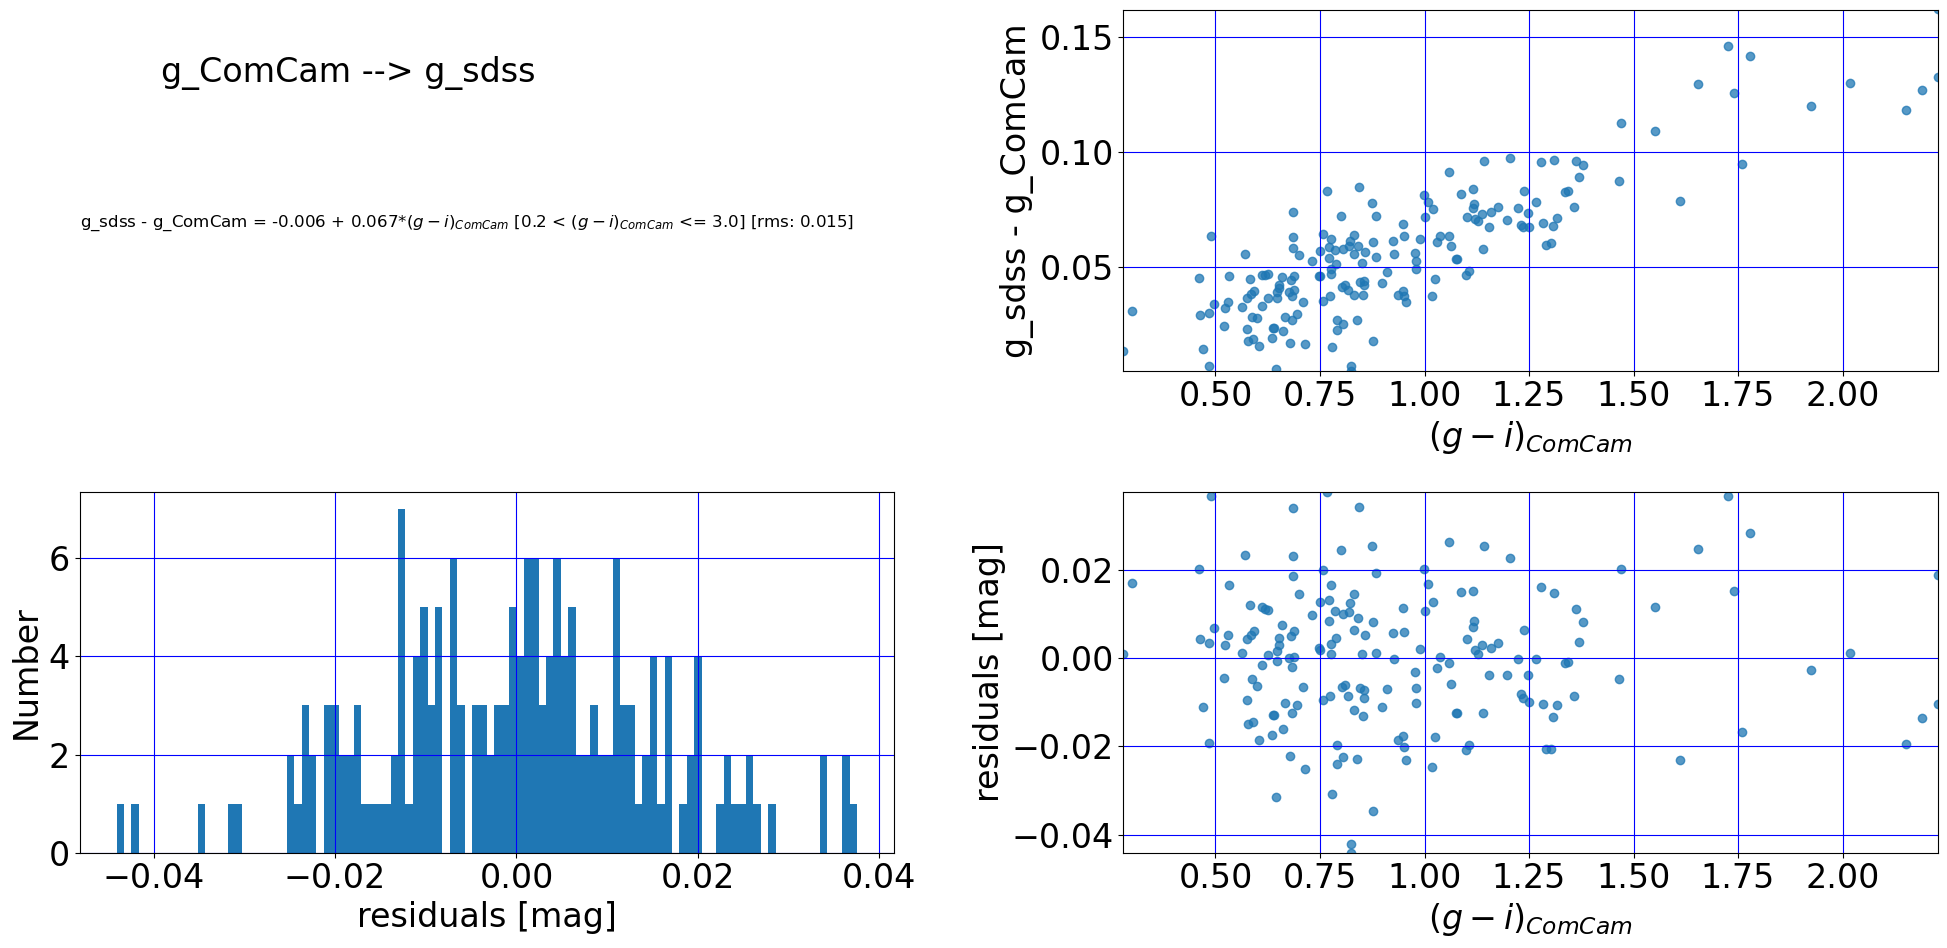

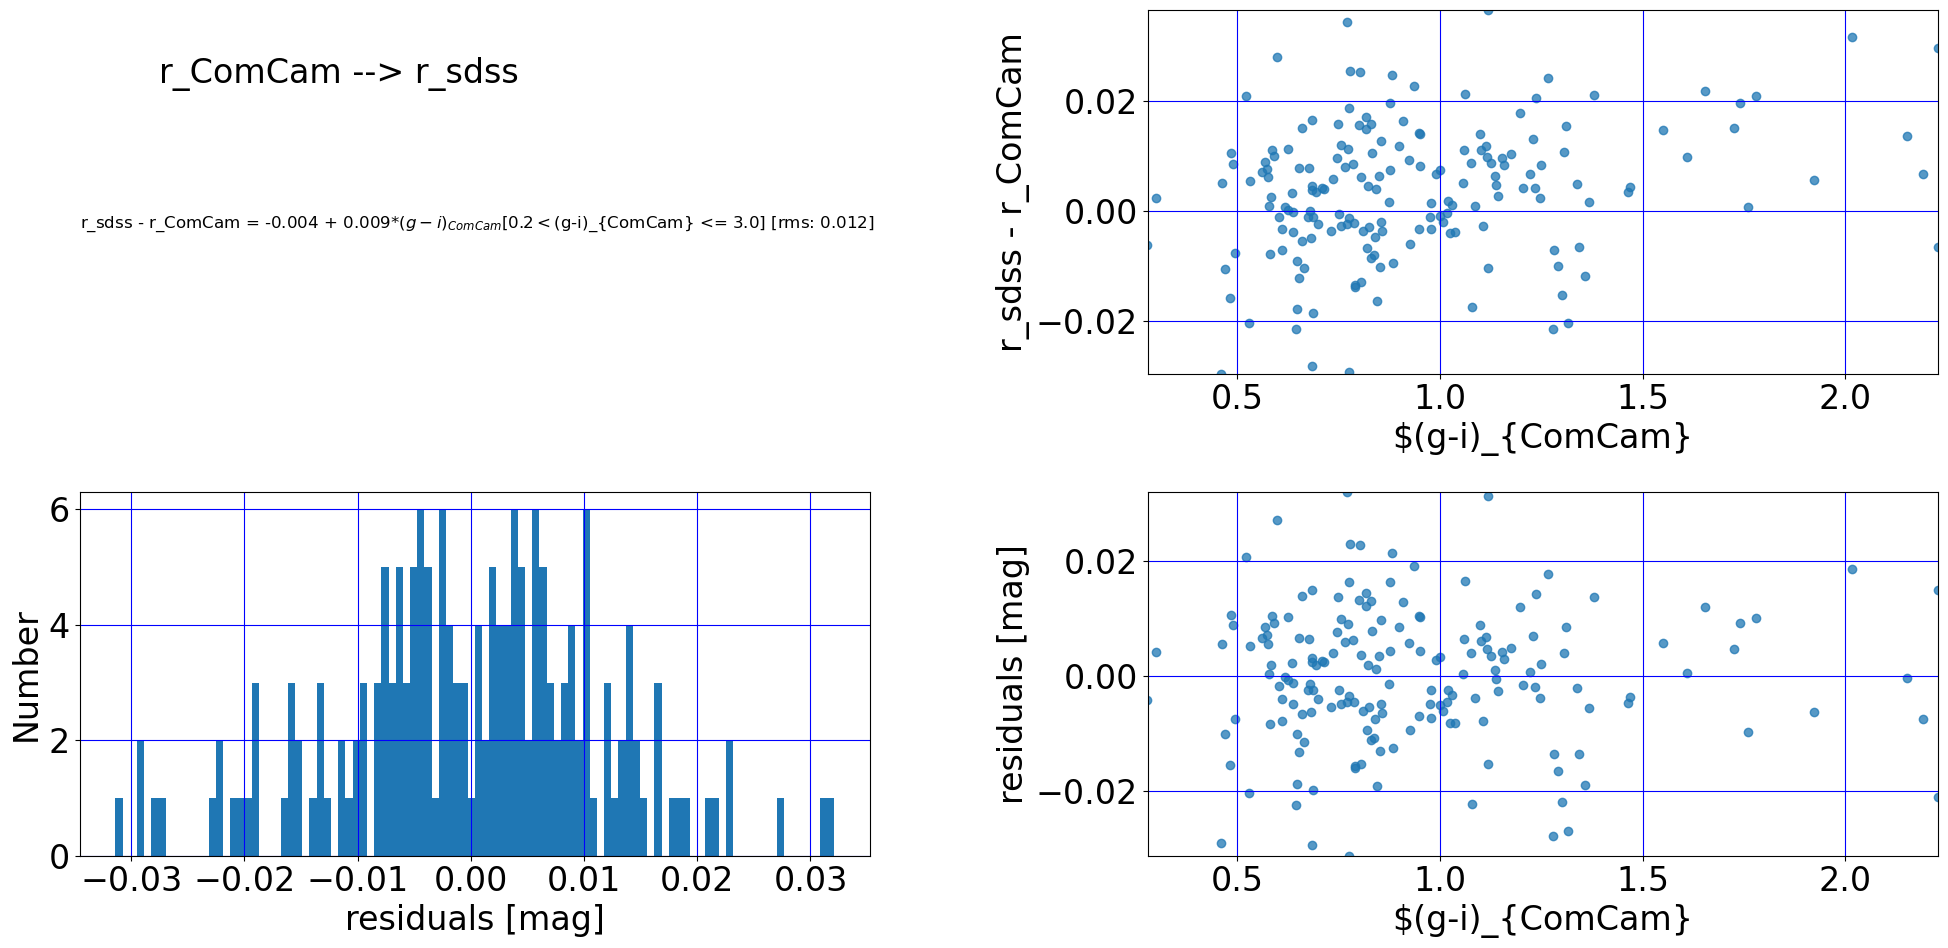

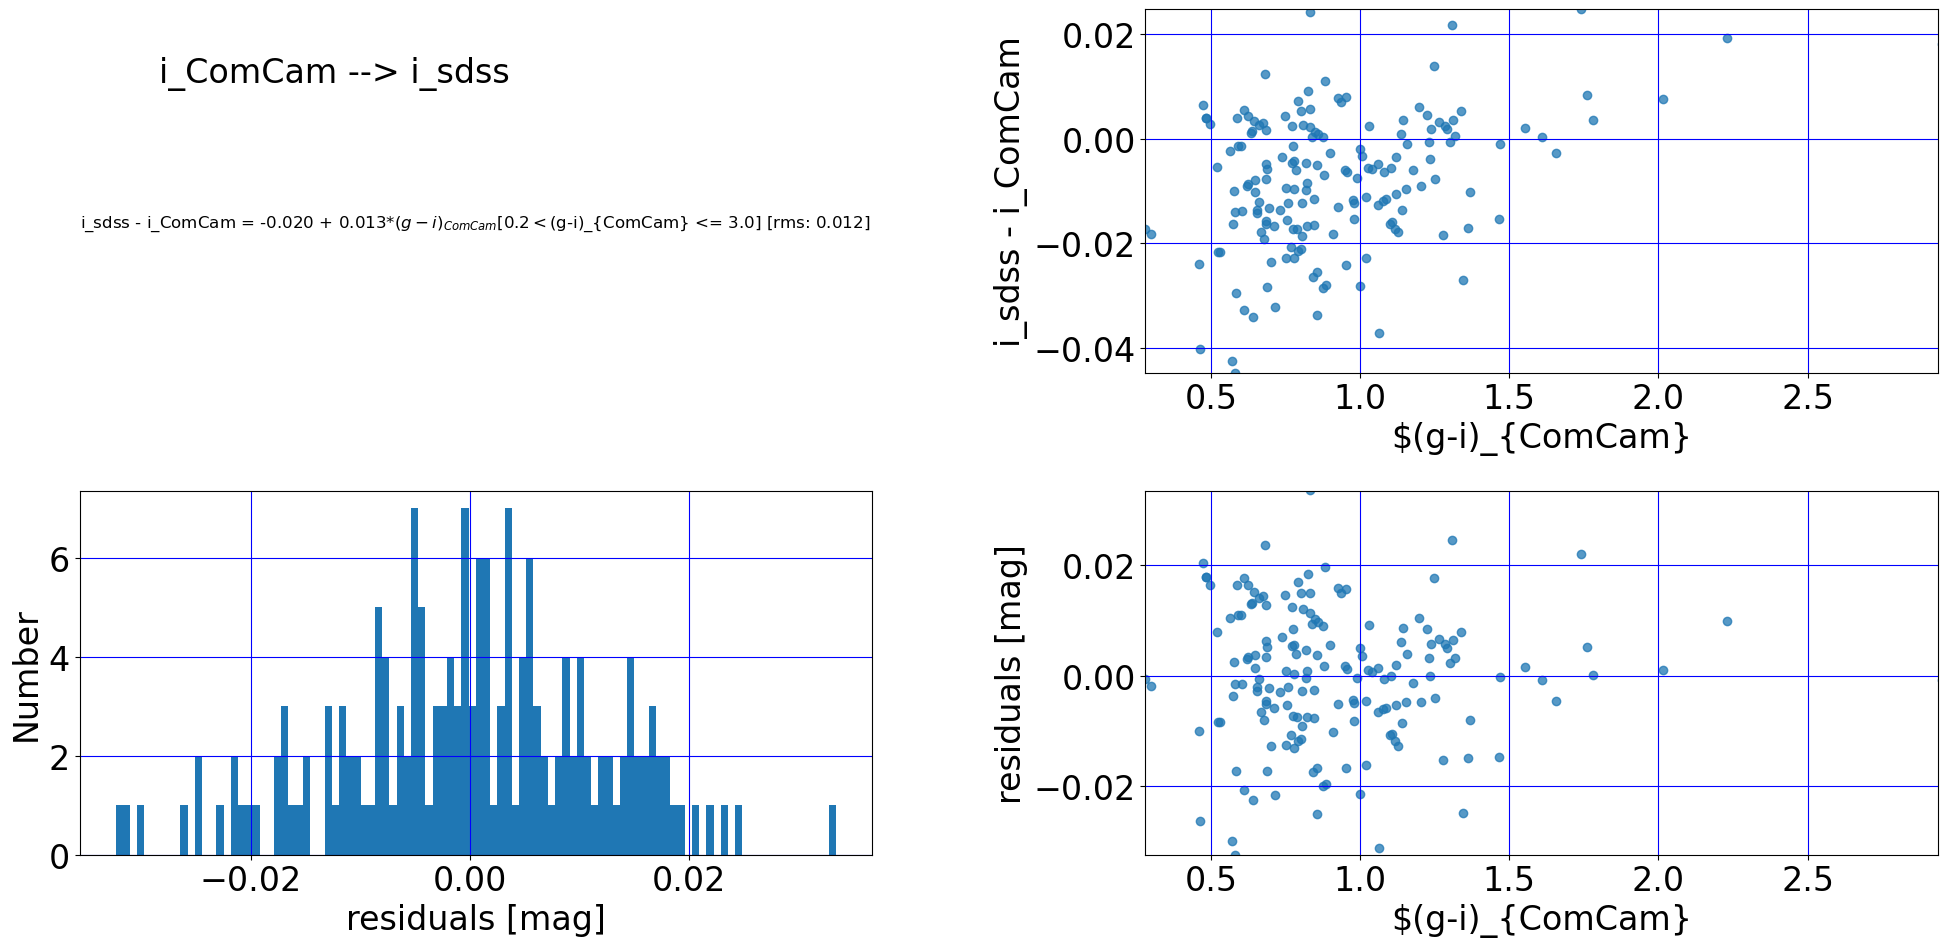

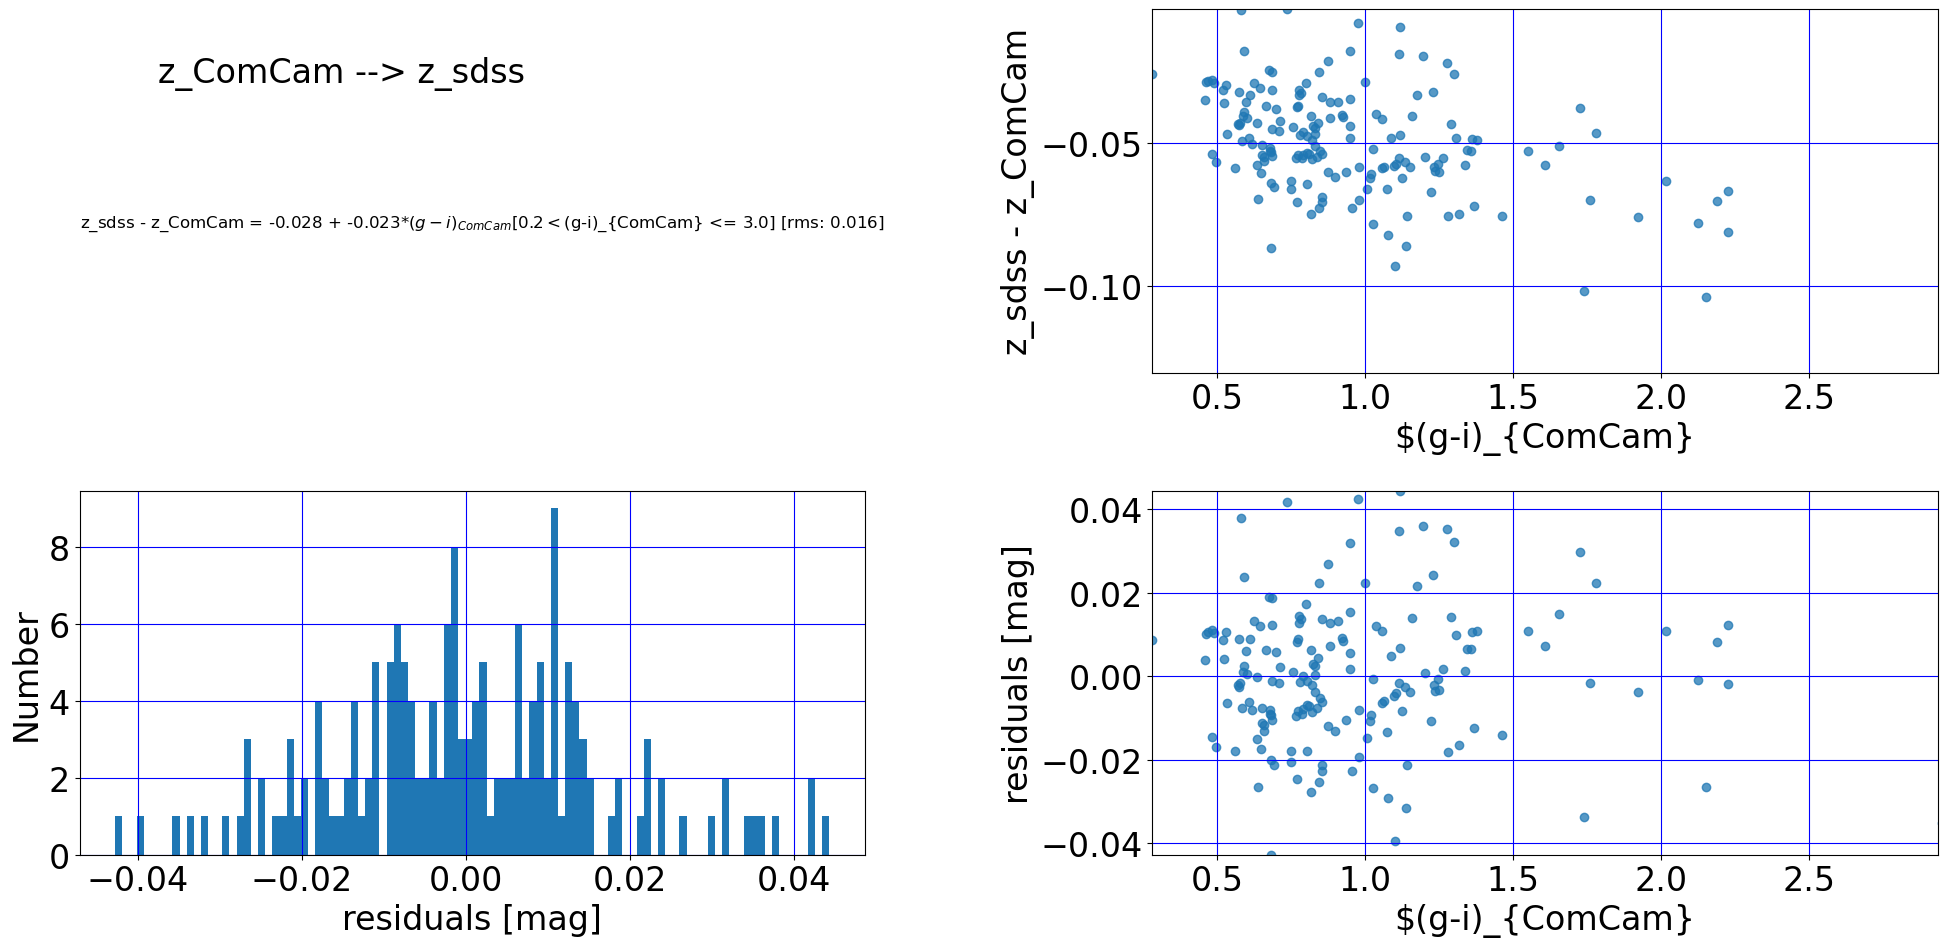

In [34]:
for band in bandList:

    print("")
    print("")
    print("")
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print(band)
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print("")

    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Create title/names for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagName = """%s - %s""" % (magName, magName_match)

    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band} - {$band}_match...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = ( abs(df['dmag']) <= 10. )
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) & (df[color_name_1].notna()) )
    mask = mask & mask1 & mask2

    # Apply the new mask to df...
    df = df[mask]

    ## Sanity check
    #df.plot(color_name_1, 'dmag', kind='scatter')

    # Calculate number of disjoint branches to fit...
    nbranches = len(color_limits_1_dict[band]) - 1
    if verbose > 0: print(band, color_limits_1_dict[band], nbranches)

    
    # Reset bluest color limit in bluest branch to color1_min
    #  and reddest color limit in reddest branch to color1_max, 
    #  after excluding above mask...
    #dftmp = df[mask]
    dftmp = df
    color1_desc = dftmp[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*(color1_desc['0.01%']-0.05))/10.
    color1_max = math.ceil(10*(color1_desc['99.99%']+0.05))/10.
    color_limits_1_dict[band][0] = color1_min
    color_limits_1_dict[band][nbranches] = color1_max
    if verbose > 0: print(band, color_limits_1_dict[band], nbranches)

    p_branch_list = []
    
    # Iterate, with sigma-clipping...
    df_list = []
    color1_list = []
    dmag_list = []
    res_list = []
    mask_list = []
    plot1Text = ''
    outputLine = ''
        
    for ibranch in range(nbranches):
            
        print('*********************************')
        print(ibranch, color_limits_1_dict[band][ibranch], color_limits_1_dict[band][ibranch+1])
        print('*********************************')

        # Extract branch...
        mask_branch = ( (df[color_name_1] >  color_limits_1_dict[band][ibranch]) & \
                        (df[color_name_1] <= color_limits_1_dict[band][ibranch+1]) )

        df_branch = df[mask_branch].copy()

        # ... and extract dmag's and color1's for this branch...
        dmag_branch   = df_branch.loc[:,'dmag']
        color1_branch = df_branch.loc[:,color_name_1]

        # If there are no valid colors on this branch, continue to next branch...
        if len(color1_branch) < 1:
            continue
                
        # Perform fit for each disjoint branch...
        print("mask_branch length (before): " , len(mask_branch))
        print("dmag_branch length:  ", len(dmag_branch))
        print("color1_branch length:  ", len(color1_branch))
        p_branch, perr_branch, color1_branch, dmag_branch, res_branch, stddev_branch = \
                                poly_fit_with_sigma_clip(color1_branch, dmag_branch, degree=norder)
        print("mask_branch length (after): " , len(mask_branch))

        # Print coefficients and estimated statistical errors in the coefficients
        for i, (p, perr) in enumerate(zip(p_branch, perr_branch)):
            print(f'p_{len(p_branch)-i-1} = {p:.6f} ± {perr:.6f}')
      
        # Prepare some text output for plots...
        #  Recall that np.polyfit returns the coefficients from highest order to lowest
        #  (This is opposite of the order the coefficients in older versions of this notebook
        #   that did not use np.polyfit for the polynomial fits)
        if norder == 1:
            plot1Text1 = """%s = %.3f + %.3f*%s [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[1], p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        elif norder == 2:
            plot1Text1 = """%s = %.3f + %.3f*%s + %.3f*%s^2  [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[2], p_branch[1], colorLabel_1, p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        else:
            plot1Text1 = ''
            
        plot1Text = """%s\n%s""" % (plot1Text, plot1Text1)
        
        print(plot1Text1)                        
 
            
        # Append branch df and mask to the df_list and mask_list lists, respectively...
        #df_list.append(df_branch.copy())
        #mask_list.append(mask_branch.copy())
        color1_list.append(color1_branch.copy())
        dmag_list.append(dmag_branch.copy())
        res_list.append(res_branch.copy())
        mask_list.append(mask_branch.copy())
        
    # Concatenate the color1, dmag, res, and mask lists for all the branches...
    color1 = pd.Series(np.concatenate(color1_list))
    dmag = pd.Series(np.concatenate(dmag_list))
    res = pd.Series(np.concatenate(res_list))
    mask = pd.Series(np.concatenate(mask_list))
    
    # Calculate the standard deviation for the full piecewise fit...
    stddev = res.std()


    # Output best fits to screen...
    if verbose > 0:
        print("")
        print(title)
        print(plot1Text)
        print("")
    
    # Create QA plots...
    #res =  df.loc[:,'res']
    #dmag =  df.loc[:,'dmag']
    #color1 = df.loc[:,color_name_1]
    #stddev = df['res'].std()
    outputFileName = """%s.dmag_%s-%s.%s.norder%d.qa1.png""" % \
        (qaFileBaseName, magName, magName_match, color_name_1, norder)
    status = transform1ColorQAPlots1a(dmag, color1, res, norder, title, plot1Text, 
                                 dmagName, colorLabel_1, stddev, outputFileName)  
    
            



In [35]:
raise StopExecution

## 12.  Sandbox

In [ ]:
# Example with plotting
import matplotlib.pyplot as plt

band = 'g'

magName_ComCam = """%s_ComCam""" % (band)
magErrName_ComCam = """%s_err_ComCam""" % (band)
magName_ps1 = """%s_ps1""" % (band)
magErrName_ps1 = """%s_err_ps1""" % (band)
    
# Grab the original version of df from the backup copy...
df = df_orig.copy()

# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

# Update dmag column for {$band}_des - {$band}_ComCam...
if toComCam:
    df.loc[:,'dmag'] = df.loc[:,magName_ComCam] - df.loc[:,magName_ps1]
else:
    df.loc[:,'dmag'] = df.loc[:,magName_ps1] - df.loc[:,magName_ComCam]
        
# Update mask...
mask1 = abs(df['dmag']) <= 10.
mask2 = abs(df[magErrName_ComCam]) <= 0.02
mask3 = abs(df[magErrName_ps1]) <= 0.01
mask = mask & mask1 & mask2 & mask3

# make a copy of original df, overwriting the old one...
df = df[mask].copy()

# Identify dmag and color1 series...
dmag =  df.loc[:,'dmag']
color1 = df.loc[:,color_name_1]


color1_array = color1
dmag_array = dmag

# Perform the fit
coeffs, mask, res, rms = poly_fit_with_sigma_clip(color1_array, dmag_array, degree=1)

# Generate smooth curve for plotting
x_smooth = np.linspace(min(color1_array), max(color1_array), 100)
y_smooth = np.polyval(coeffs, x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(color1_array[mask], dmag_array[mask], label='Used points')
plt.scatter(color1_array[~mask], dmag_array[~mask], color='red', label='Rejected points')
plt.plot(x_smooth, y_smooth, 'k-', label='Fit')
plt.xlabel('Color')
plt.ylabel('dmag')
plt.legend()
plt.title(f'Polynomial fit (RMS = {rms:.3f})')
plt.show()

# Print coefficients
for i, c in enumerate(coeffs):
    print(f'c_{len(coeffs)-i-1} = {c:.6f}')